In [6]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy import stats

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Inference Engines

1. Non-Markovian methods:
       <ul>
       <li> Grid computing</li>
       </ul>

The following code implements the grid approach to solve the coin-flipping 
problem we began to explore in Chapter 1, Thinking Probabilistically -   Bayesian
Inference Primer:

In [4]:
def posterior_grid(grid_points=100, heads=6, tosses=9):
    """
    A grid implementation for the coin-flip problem
    """
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(5, grid_points)
    likelihood = stats.binom.pmf(heads, tosses, grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

Assuming we made 4 tosses and we observe only 1 head we have the following:

In [7]:
points = 15
h, n = 1, 4
grid, posterior = posterior_grid(points, h, n)
plt.plot(grid, posterior, 'o-', label='heads = {}\ntosses = {}'.format(h, n))
plt.xlabel(r'$\theta$')
plt.legend(loc=0)

**Simple Monte carlo simulation to compute pi**

(-1.0, 1.0)

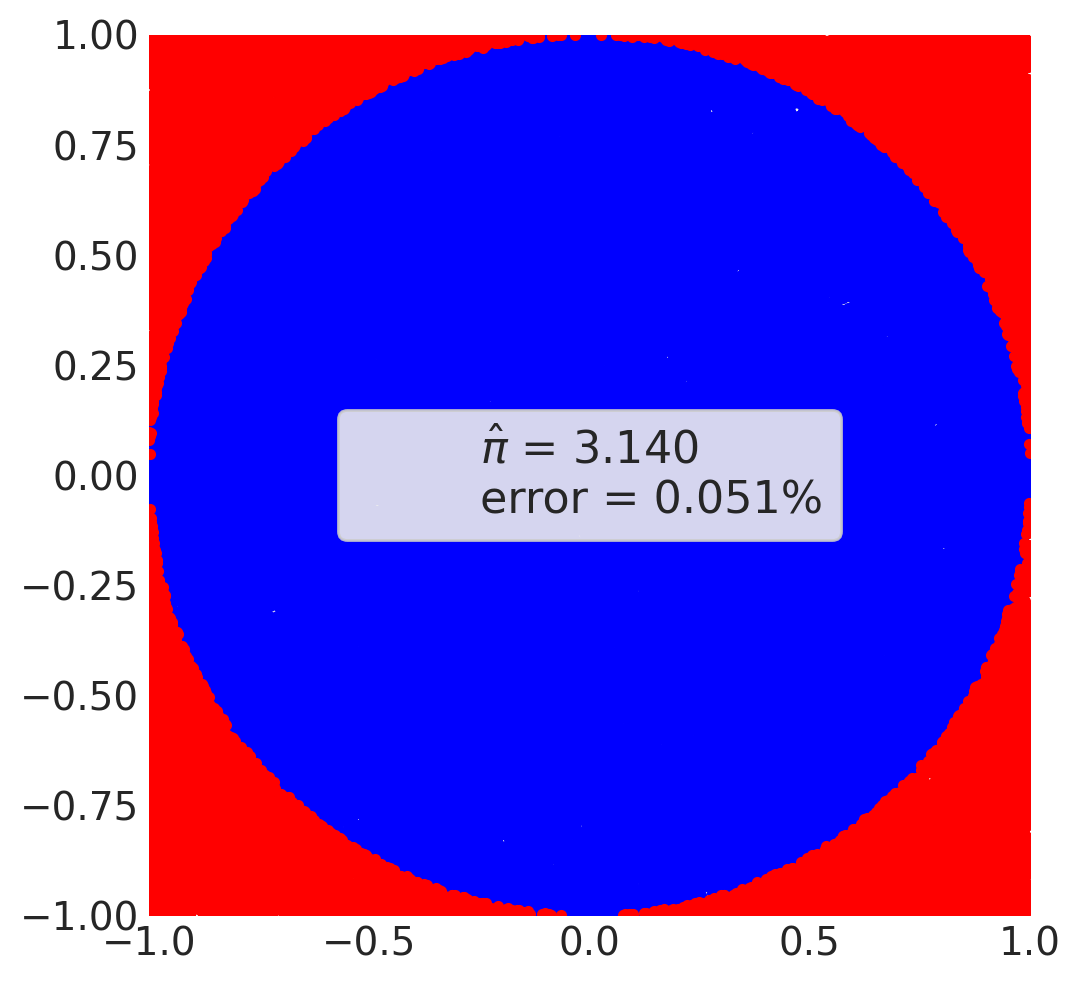

In [8]:
N = 80000
x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2)<=1
pi = inside.sum()*4/N
error = abs((pi-np.pi)/pi)* 100
outside = np.invert(inside)
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label='$\hat \pi$ = {:4.3f}\nerror = {:4.3f}%'.format(pi, error), alpha=0)
plt.axis('square')
plt.legend(frameon=True, framealpha=0.9, fontsize=16)
plt.xlim(-1,1)
plt.ylim(-1,1)

# MCMC Methods
## Metropolis Hasting
The first argument of the metropolis function is a SciPy distribution

In [9]:
def metropolis(func, steps=10000):
    """A very simple Metropolis implementation"""
    samples = np.zeros(steps)
    old_x = func.mean()
    old_prob = func.pdf(old_x)
    for i in range(steps):
        new_x = old_x + np.random.normal(0, 0.5)
        new_prob = func.pdf(new_x)
        acceptance = new_prob/old_prob
        if acceptance >= np.random.random():
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            samples[i] = old_x
    return samples

In [10]:
def normalize_list(input_list):
    # Find the minimum and maximum values in the list
    min_val = min(input_list)
    max_val = max(input_list)
    
    # Normalize each element in the list
    normalized_list = [(x - min_val) / (max_val - min_val) for x in input_list]
    
    return normalized_list

We have defined func as a beta function. We are plotting the samples 
obtained by metropolis as a histogram and also the True distribution as a  
red line

(0.0, 1.0)

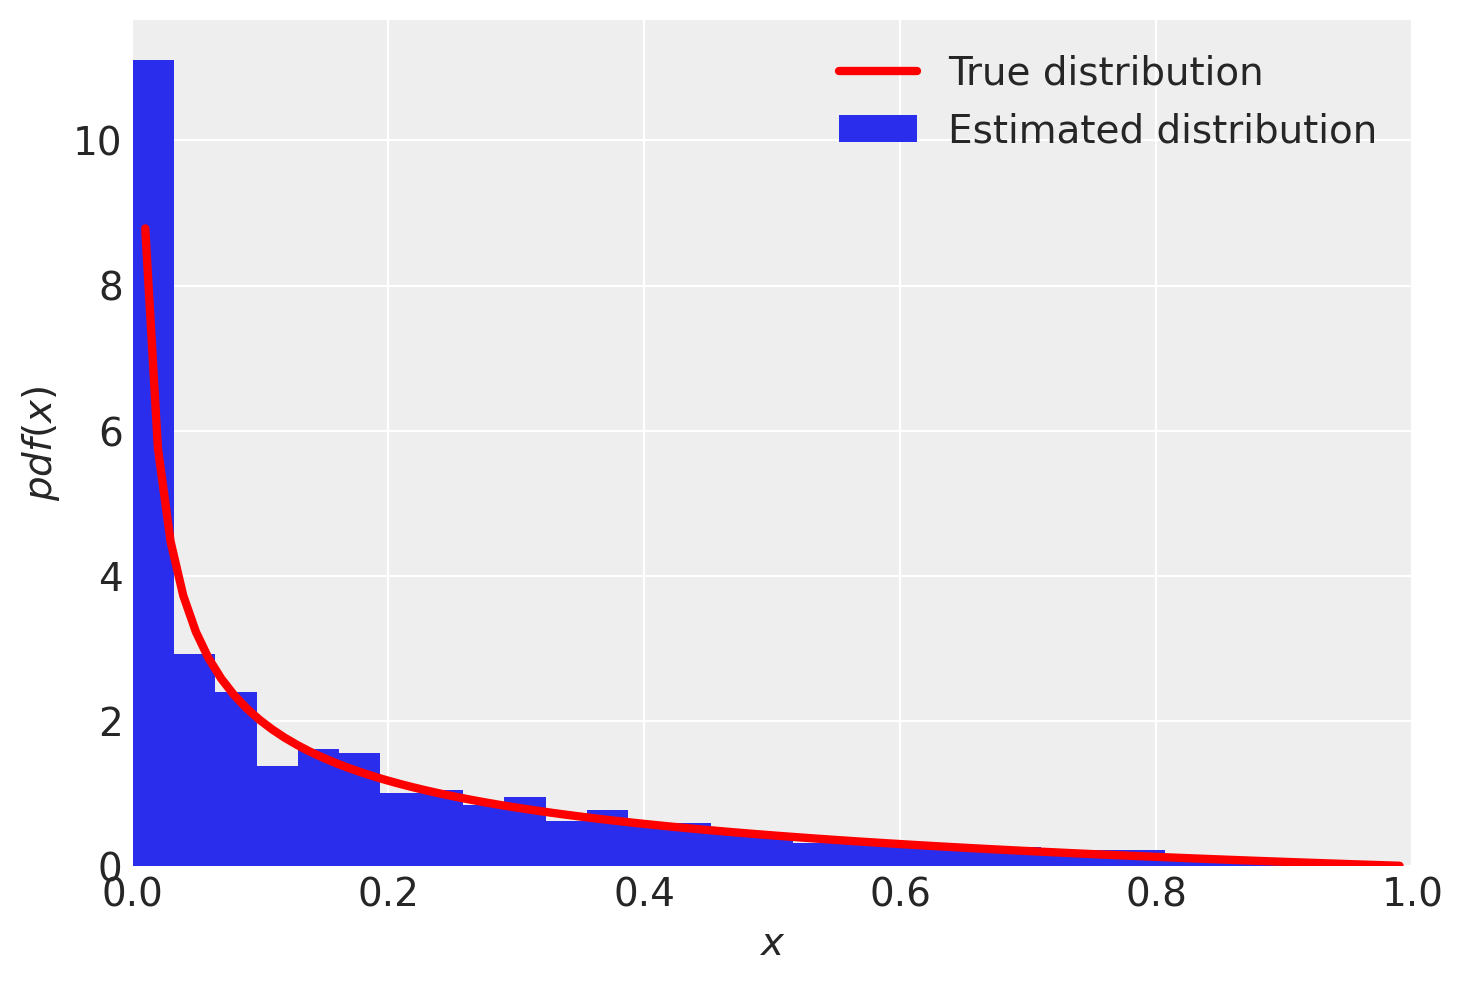

In [11]:
func = stats.beta(0.4, 2)
samples = metropolis(func)
x = np.linspace(0.01, 0.99, 100)
y = func.pdf(x)
plt.plot(x, func.pdf(x), 'r-', lw=3, label='True distribution')
plt.hist(samples, bins=30, density=True, label='Estimated distribution')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(0,1)

# PyMC5 Introduction

## Coin-flipping, the computational approach

In [17]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35   #We know theta in this case, but in real world scenario, this is what we want to approximate
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
data

array([1, 0, 0, 0], dtype=int64)

### Model Specification

In [20]:
our_first_model = pm.Model()

with our_first_model:
    #Prior
    theta = pm.Beta('theta', alpha=1, beta=1)

    # Likelihood as it has data given through observed parameter
    y = pm.Bernoulli('y', p=theta, observed=data)

### Pushing the inference button

In [21]:
with our_first_model:
    start = pm.find_MAP()
    step = pm.Metropolis()
    idata = pm.sample(1000, step=step, start=start)

C:\Users\Divya Tiwari\AppData\Local\Temp\ipykernel_996\2082593645.py:4: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  idata = pm.sample(1000, step=step, start=start)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [22]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Diagnosing the sampling process

Generally, the first task we be to check what the results look like.  
The traceplot function is ideally suited to this task

PyMC’s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named Arviz.

**Convergence**

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

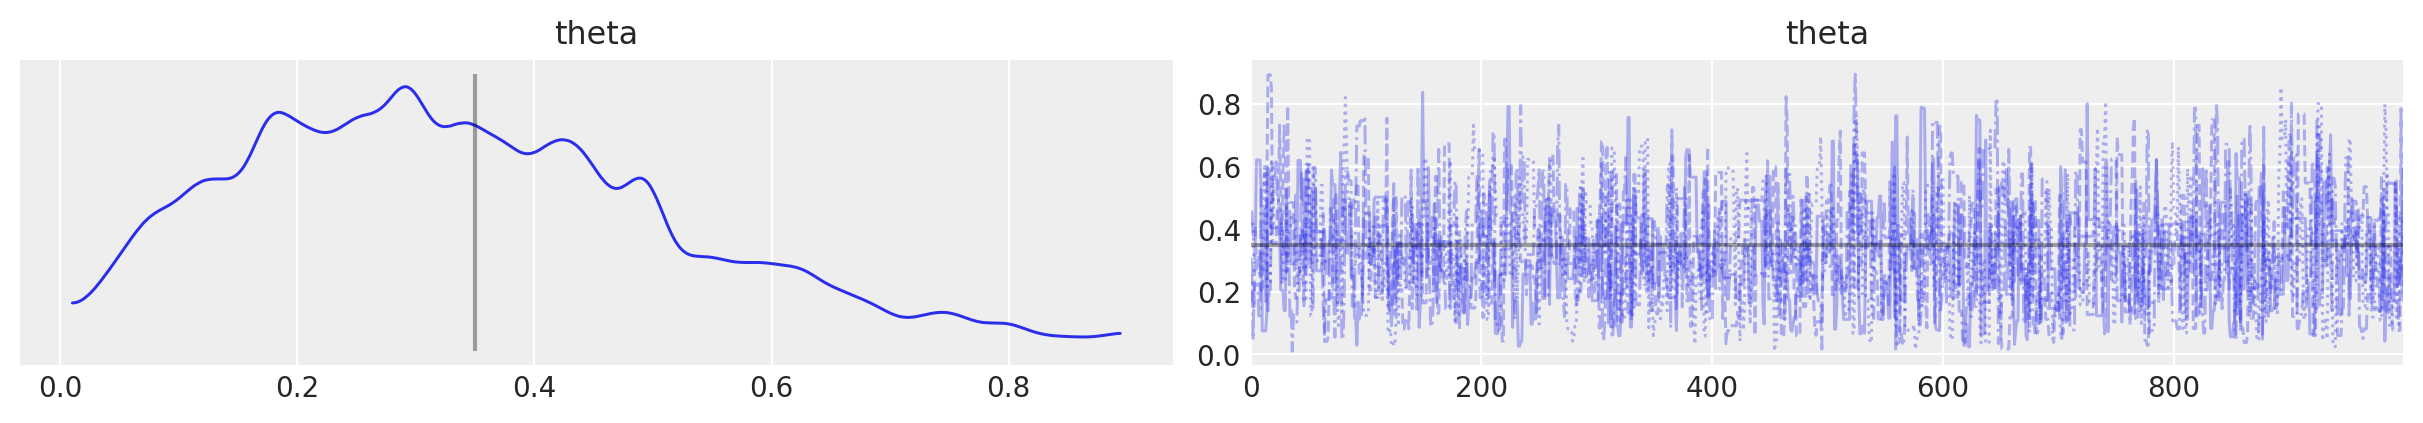

In [39]:
# Create a trace plot with a vertical line at the true value of theta_real
az.plot_trace(idata, combined=True, lines=[("theta", {}, [theta_real])])

In [35]:
with our_first_model:
    step = pm.Metropolis()
    multi_trace = pm.sample(1000, step=step, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [42]:
az.plot_trace(multi_trace, combined=False, lines=[("theta", {}, [theta_real])])

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

In [43]:
az.summary(multi_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.332  0.167   0.058    0.648      0.005    0.004    1073.0    1079.0   

       r_hat  
theta    1.0

C:\Users\Divya Tiwari\anaconda3\envs\probability\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
C:\Users\Divya Tiwari\anaconda3\envs\probability\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

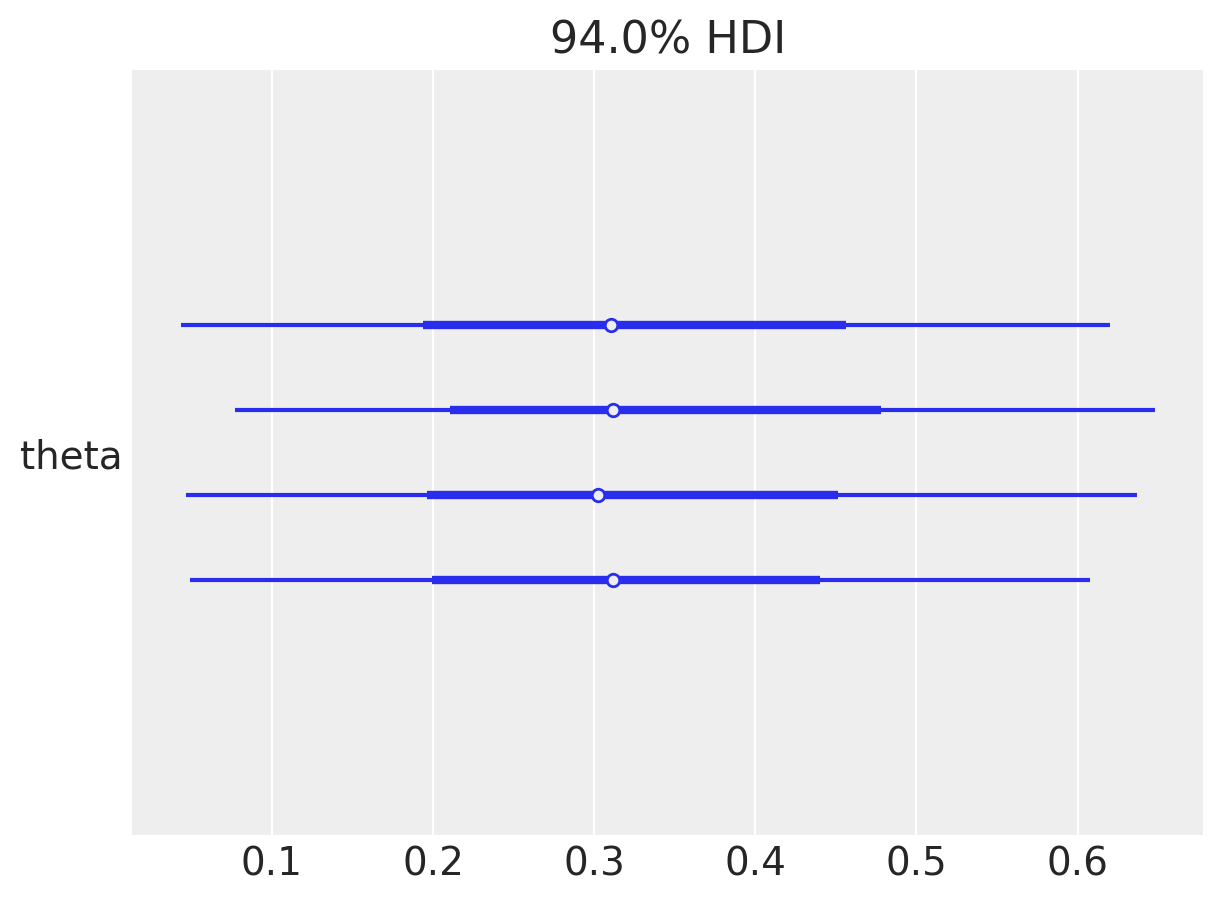

In [44]:
az.plot_forest(multi_trace, var_names=['theta'])

**Autocorrelation**

<Axes: title={'center': 'theta'}>

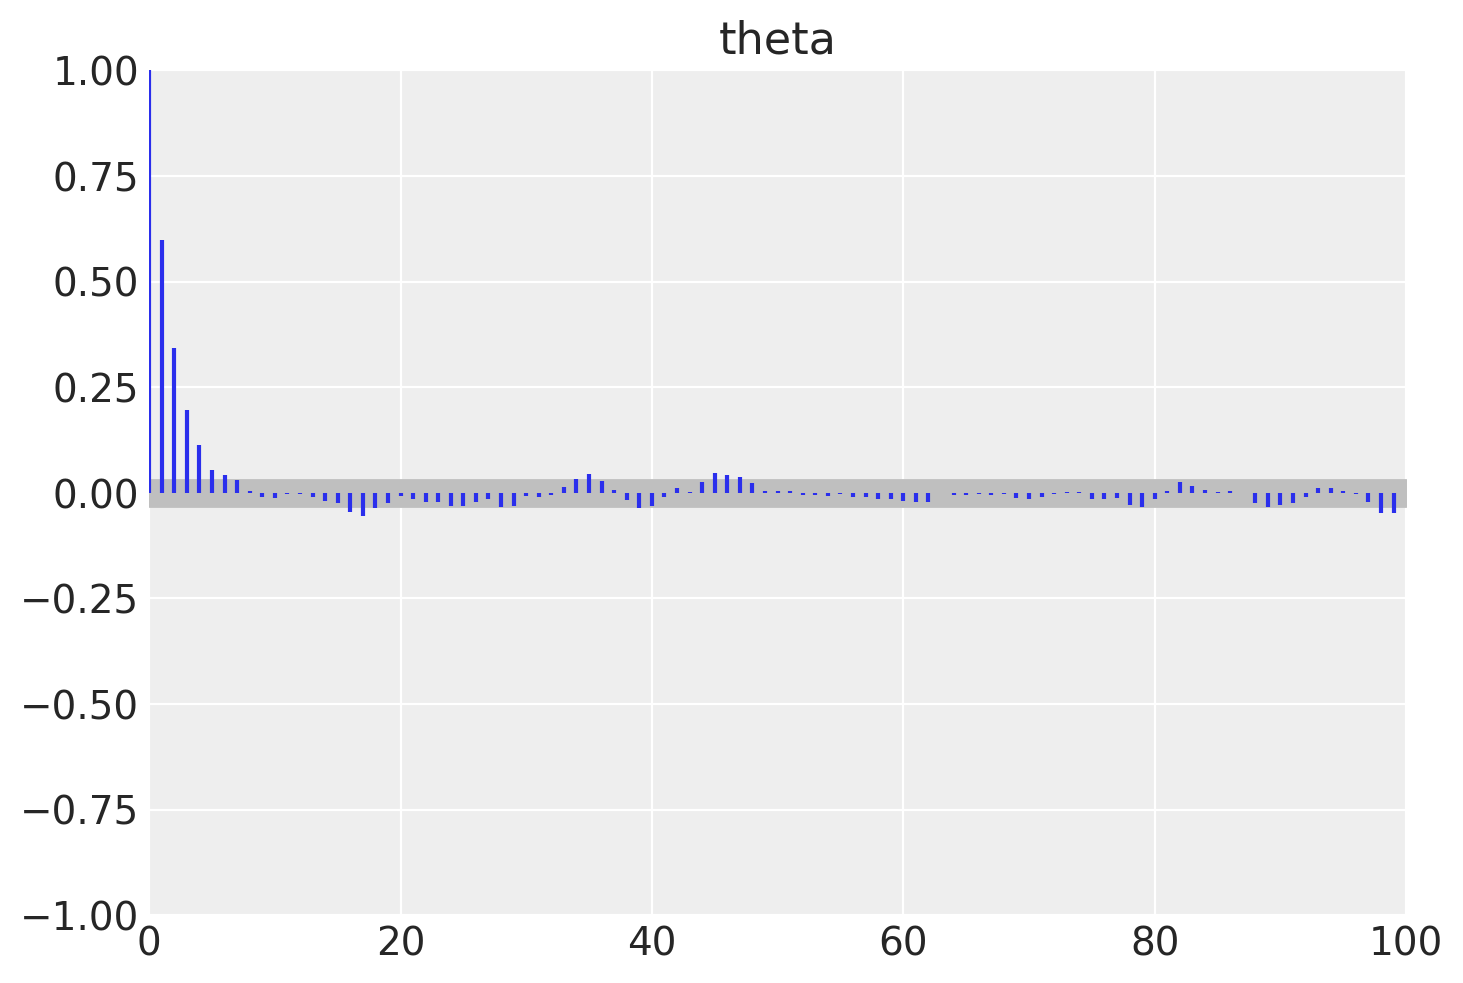

In [50]:
az.plot_autocorr(multi_trace, combined=True)

**Effective Size**

In [51]:
 pm.effective_n(multi_trace)['theta']

AttributeError: module 'pymc' has no attribute 'effective_n'